# Configuration

In [ ]:
%%capture
!pip install "unsloth[colab-new]" "huggingface_hub[hf_xet]" triton==3.2.0 unsloth_zoo

In [ ]:
import os
import shutil
from collections import defaultdict
from datetime import datetime

from datasets import load_dataset, load_from_disk, Image
from google.colab import drive
from huggingface_hub import hf_hub_download
from sklearn.metrics import classification_report  # noqa
from tqdm import tqdm
from unsloth import FastVisionModel
from unsloth.chat_templates import get_chat_template

DATASET_NAME = "QCRI/CrisisMMD"
DATASET_TRANSLATION_NAME = "josecols/damage-mmd"
DRIVE_MOUNT_POINT = "/content/drive"
DRIVE_DATASET_PATH = os.path.join(DRIVE_MOUNT_POINT, "MyDrive", "datasets", "CrisisMMD")
MAX_SEQ_LENGTH = 2048
LABEL_NAMES = ["little", "mild", "severe"]
DATE_STRING = datetime.today().strftime("%d %b %Y")
BASE_MODEL = "unsloth/Llama-3.2-11B-Vision-Instruct"
BASE_MODEL = "josecols/llama-damagemmd-en"


def mount_drive():
    drive.mount(DRIVE_MOUNT_POINT)


def download_file(row):
    return hf_hub_download(
        repo_id=DATASET_NAME,
        repo_type="dataset",
        filename=row["image_path"],
    )


def download_images(dataset):
    for split in dataset:
        paths = list(
            tqdm(
                map(download_file, dataset[split]),
                total=len(dataset[split]),
                desc=f"Downloading {split} images",
            )
        )
        dataset[split] = dataset[split].remove_columns(["image"])
        dataset[split] = dataset[split].add_column("image", paths)

    return dataset


def use_dataset_translation(dataset, language):
    translation = load_dataset(DATASET_TRANSLATION_NAME)

    for split in dataset.keys():
        translated_column = f"tweet_text_{language}"
        dataset[split] = dataset[split].remove_columns("tweet_text")
        dataset[split] = dataset[split].add_column(
            "tweet_text", translation[split][translated_column]
        )


def save_to_drive(dataset):
    for split in dataset:
        split_folder = os.path.join(DRIVE_DATASET_PATH, split, "images")
        os.makedirs(split_folder, exist_ok=True)

        new_paths = []
        for img_path in dataset[split]["image"]:
            filename = os.path.basename(img_path)
            dest_path = os.path.join(split_folder, filename)
            if not os.path.exists(dest_path):
                shutil.copy(img_path, dest_path)

            new_paths.append(dest_path)

        dataset[split] = dataset[split].remove_columns("image")
        dataset[split] = dataset[split].add_column("image", new_paths)

    dataset.save_to_disk(DRIVE_DATASET_PATH)


def load_from_drive():
    mount_drive()

    if os.path.exists(DRIVE_DATASET_PATH):
        print(f"Loading dataset from {DRIVE_DATASET_PATH} ...")
        data = load_from_disk(DRIVE_DATASET_PATH)
    else:
        print("Dataset not found in Drive. Downloading from Hugging Face ...")
        data = load_dataset(DATASET_NAME, "damage")
        data = download_images(data)
        save_to_drive(data)

    data = data.cast_column("image", Image(decode=True))

    return data


def load_model():
    model, tokenizer = FastVisionModel.from_pretrained(
        BASE_MODEL,
        load_in_4bit=True,
        max_seq_length=MAX_SEQ_LENGTH,
        use_gradient_checkpointing="unsloth",
    )
    return model, tokenizer


def format_chatml(text: str, image=None, label: int | None = None) -> list:
    image_message = {"type": "image", "image": image} if image else {"type": "image"}
    text_message = {
        "type": "text",
        "text": f"Please answer with 'little', 'mild', or 'severe' only. Decide if the following tweet and the attached image indicate little, mild, or severe damage.: \n{text}\n If there is little or no damage please answer 'little', if there is mild damage please answer 'mild', if there is severe damage please answer 'severe'. Make your decision based on the image content and the whole text.",
    }
    messages = [
        {
            "role": "user",
            "content": [image_message, text_message],
        }
    ]

    if label is not None:
        messages.append(
            {
                "role": "assistant",
                "content": [{"type": "text", "text": LABEL_NAMES[label]}],
            }
        )

    return messages


def get_chatml_messages(samples: dict, include_labels: bool = False):
    fields = zip(samples["tweet_text"], samples["image"], samples["label"])

    return [
        format_chatml(text, image, label if include_labels else None)
        for text, image, label in fields
    ]


def resize_image(image, max_size: int = 1024):
    thumbnail = image.copy()
    thumbnail.thumbnail((max_size, max_size))

    return thumbnail


def extract_image(chat):
    index = -1
    for i, c in enumerate(chat[0]["content"]):
        if c["type"] == "image":
            index = i
            break

    image = chat[0]["content"][index]["image"]
    thumbnail = resize_image(image)
    del chat[0]["content"][index]["image"]

    return thumbnail


def tokenize_chatml(tokenizer, chat):
    image = extract_image(chat)
    text = tokenizer.apply_chat_template(chat, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")
    input_length = inputs["input_ids"].shape[1]

    return inputs, input_length


def detect_label(prediction):
    prediction = prediction.lower()
    for label in LABEL_NAMES:
        if label in prediction:
            return label

    return "<unknown>"


def parse_outputs(outputs, tokenizer, input_length):
    prediction = tokenizer.batch_decode(
        outputs[:, input_length:], skip_special_tokens=True
    )[0].strip()

    return detect_label(prediction)


def make_predictions(model, tokenizer, data) -> list:
    FastVisionModel.for_inference(model)
    messages = get_chatml_messages(data)

    predictions = []
    for chat in tqdm(messages, desc="Predictions"):
        inputs, input_length = tokenize_chatml(tokenizer, chat)

        outputs = model.generate(
            **inputs,
            use_cache=True,
            do_sample=False,
            dola_layers="high",
            max_new_tokens=16,
        )

        prediction = parse_outputs(outputs, tokenizer, input_length)
        predictions.append(prediction)

    return predictions


def classification_report_per_event(test_true_labels, test_pred_labels, data):
    event_names = data["event_name"]

    per_event = defaultdict(lambda: {"y_true": [], "y_pred": []})
    for i, event in enumerate(event_names):
        per_event[event]["y_true"].append(test_true_labels[i])
        per_event[event]["y_pred"].append(test_pred_labels[i])

    for event, values in per_event.items():
        print(event)
        print(classification_report(values["y_true"], values["y_pred"], digits=4))
        print()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# Dataset

In [ ]:
dataset = load_from_drive()
test_true_labels = [LABEL_NAMES[label] for label in dataset["test"]["label"]]

Mounted at /content/drive
Loading dataset from /content/drive/MyDrive/datasets/CrisisMMD ...


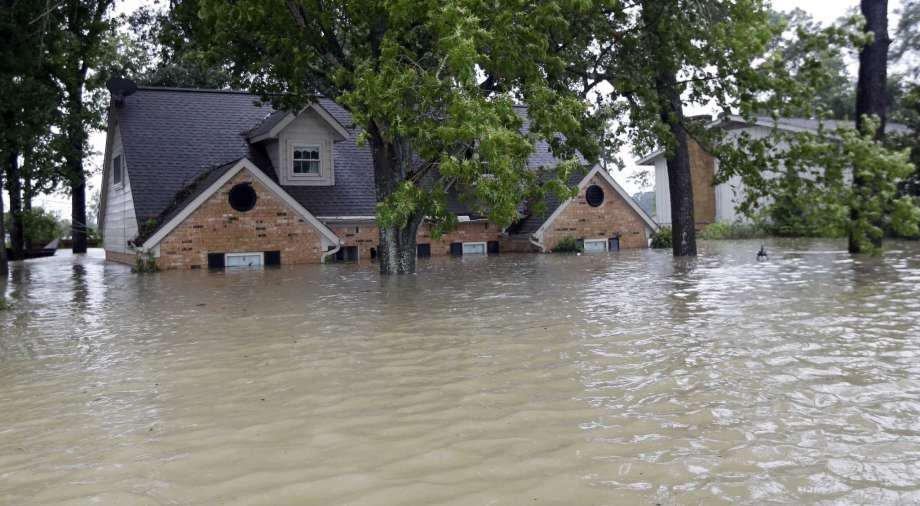

In [ ]:
dataset["train"]["image"][0]

In [ ]:
# use_dataset_translation(dataset, "hi")
# dataset["train"]["tweet_text"][0]

# Fine-tuning

In [ ]:
model, tokenizer = load_model()

==((====))==  Unsloth 2025.5.9: Fast Mllama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/56.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [ ]:
train_messages = get_chatml_messages(dataset["train"], include_labels=True)

In [ ]:
train_messages[0]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=920x506>},
   {'type': 'text',
    'text': "Please answer with 'little', 'mild', or 'severe' only. Decide if the following tweet and the attached image indicate little, mild, or severe damage.: \nRT @tveitdal: जहां हार्वे सबसे ज्यादा मार रहा है, 80% में बाढ़ बीमा नहीं है https://t.co/p0xVVe3kNP https://t.co/xaHjtRRGMq\n If there is little or no damage please answer 'little', if there is mild damage please answer 'mild', if there is severe damage please answer 'severe'. Make your decision based on the image content and the whole text."}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'severe'}]}]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Making `model.base_model.model.language_model` require gradients


In [ ]:
model.print_trainable_parameters()

trainable params: 52,428,800 || all params: 10,722,649,635 || trainable%: 0.4890


In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig


FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=train_messages,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        # max_steps=30,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=MAX_SEQ_LENGTH,
    ),
)

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,468 | Num Epochs = 1 | Total steps = 308
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 52,428,800/11,000,000,000 (0.48% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.938200
2,2.836300
3,2.765200
4,2.664800
5,2.424100
6,2.151700
7,1.882600
8,1.701400
9,1.262900
10,1.328000


# Saving

In [ ]:
model.push_to_hub_merged("josecols/llama-damagemmd-hi", tokenizer)

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00005.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  20%|██        | 1/5 [03:12<12:48, 192.22s/it]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  40%|████      | 2/5 [06:49<10:20, 206.94s/it]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  60%|██████    | 3/5 [10:37<07:13, 216.66s/it]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  80%|████████  | 4/5 [15:01<03:55, 235.39s/it]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [16:11<00:00, 194.26s/it]


# Inference

In [ ]:
model, tokenizer = load_model()

==((====))==  Unsloth 2025.5.9: Fast Mllama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/56.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [ ]:
dataset["test"]["tweet_text"][1]

'Some of the devastation from #Harvey friends and family who lost everything ὢ2 prayers neededὉ4 @DonnieWahlberg #BH❤ https://t.co/2rNeqYEEQJ'

In [ ]:
test_pred_labels = make_predictions(model, tokenizer, dataset["test"])

Predictions: 100%|██████████| 529/529 [13:33<00:00,  1.54s/it]


In [ ]:
print(classification_report(test_true_labels, test_pred_labels, digits=4))

              precision    recall  f1-score   support

      little     0.7368    0.3944    0.5138        71
        mild     0.5789    0.2619    0.3607       126
      severe     0.7327    0.9578    0.8303       332

    accuracy                         0.7164       529
   macro avg     0.6828    0.5380    0.5682       529
weighted avg     0.6966    0.7164    0.6759       529



In [ ]:
classification_report_per_event(test_true_labels, test_pred_labels, dataset["test"])

hurricane_maria
              precision    recall  f1-score   support

      little     0.3333    0.1111    0.1667         9
        mild     0.6923    0.1915    0.3000        47
      severe     0.6496    0.9870    0.7835        77

    accuracy                         0.6466       133
   macro avg     0.5584    0.4299    0.4167       133
weighted avg     0.6433    0.6466    0.5709       133


hurricane_harvey
              precision    recall  f1-score   support

      little     0.8182    0.4737    0.6000        19
        mild     0.6500    0.3939    0.4906        33
      severe     0.7624    0.9625    0.8508        80

    accuracy                         0.7500       132
   macro avg     0.7435    0.6100    0.6471       132
weighted avg     0.7423    0.7500    0.7247       132


hurricane_irma
              precision    recall  f1-score   support

      little     0.7826    0.4500    0.5714        40
        mild     0.5000    0.3667    0.4231        30
      severe     0.5733  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Visualizations

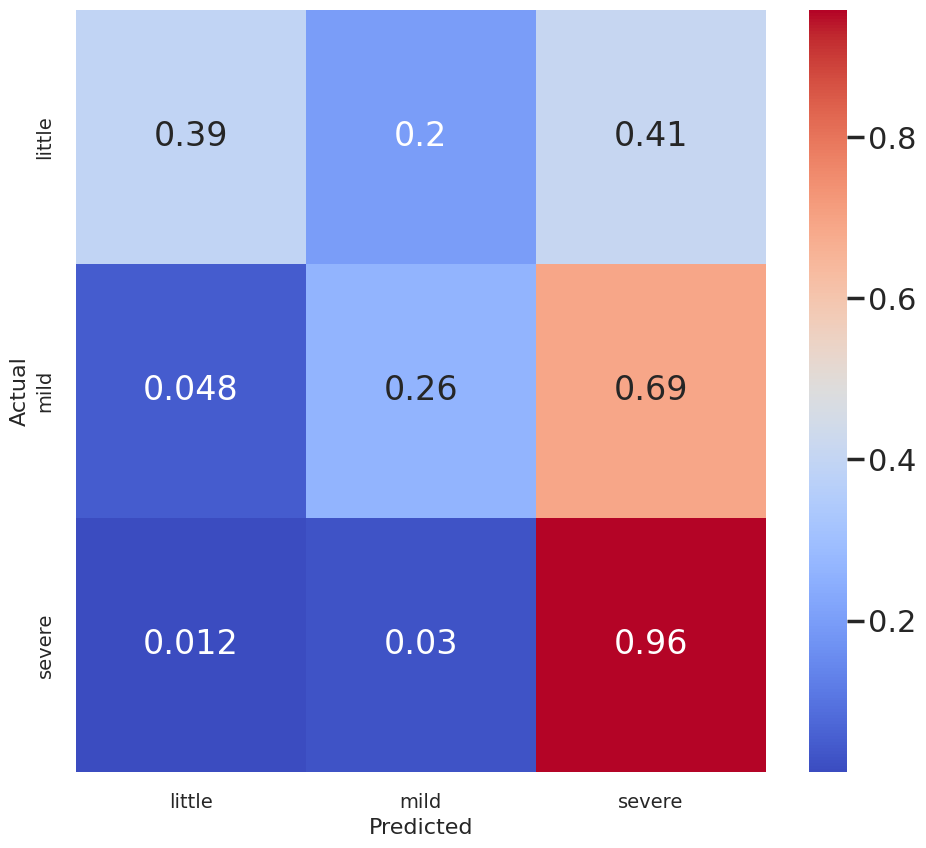

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")
sns.set_context("poster")

cm = confusion_matrix(test_true_labels, test_pred_labels)
cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cm, index=LABEL_NAMES, columns=LABEL_NAMES)

plt.figure(figsize=(10, 9))
sns.heatmap(
    cm_df,
    annot=True,
    cmap="coolwarm",
)
plt.ylabel("Actual", fontsize=16)
plt.xlabel("Predicted", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("en_cm.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()